In [63]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [86]:
# simulation and data collection
simulationSteps = 500
cMatrix = np.diag(np.ones(100)) + np.ones((100,100))*0.9
np.fill_diagonal(cMatrix, 1)
model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                leverageRatio = 10.0,                                     # leverage ratio upper bound for all banks
                depositReserve = 0.80,                                     # capital reserve as a ratio of portfolio value
                num_borrowing= 20,                                        # number of borrowing request per bank per step
                sizeOfBorrowing = 1.0/3,                                      # size of borrowing as a ratio of equity capital
                num_banks=100,                                            # number of banks in the system 
                alpha = 0.5,                                              # portfolio recovery rate                           
                beta = 0.9,                                               # interbank loan recovery rate
                fedRate = 0.04,                                            # interest rate on borrowing   
                portfolioReturnRate = 0.10,          
                # return rate on portfolio
                returnVolatiliy = 0.18,
                returnCorrelation = cMatrix,
                liquidityShockNum = 1,                                    # number of liquidity shocks per step      
                shockSize = 0.0,                                          # size of the shock
                shockDuration = [300, 305]) # duration of the shock
                
model.datacollector.collect(model)
for i in tqdm(range(simulationSteps)):
    model.simulate()
    
agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

100%|██████████| 500/500 [00:33<00:00, 15.10it/s] 


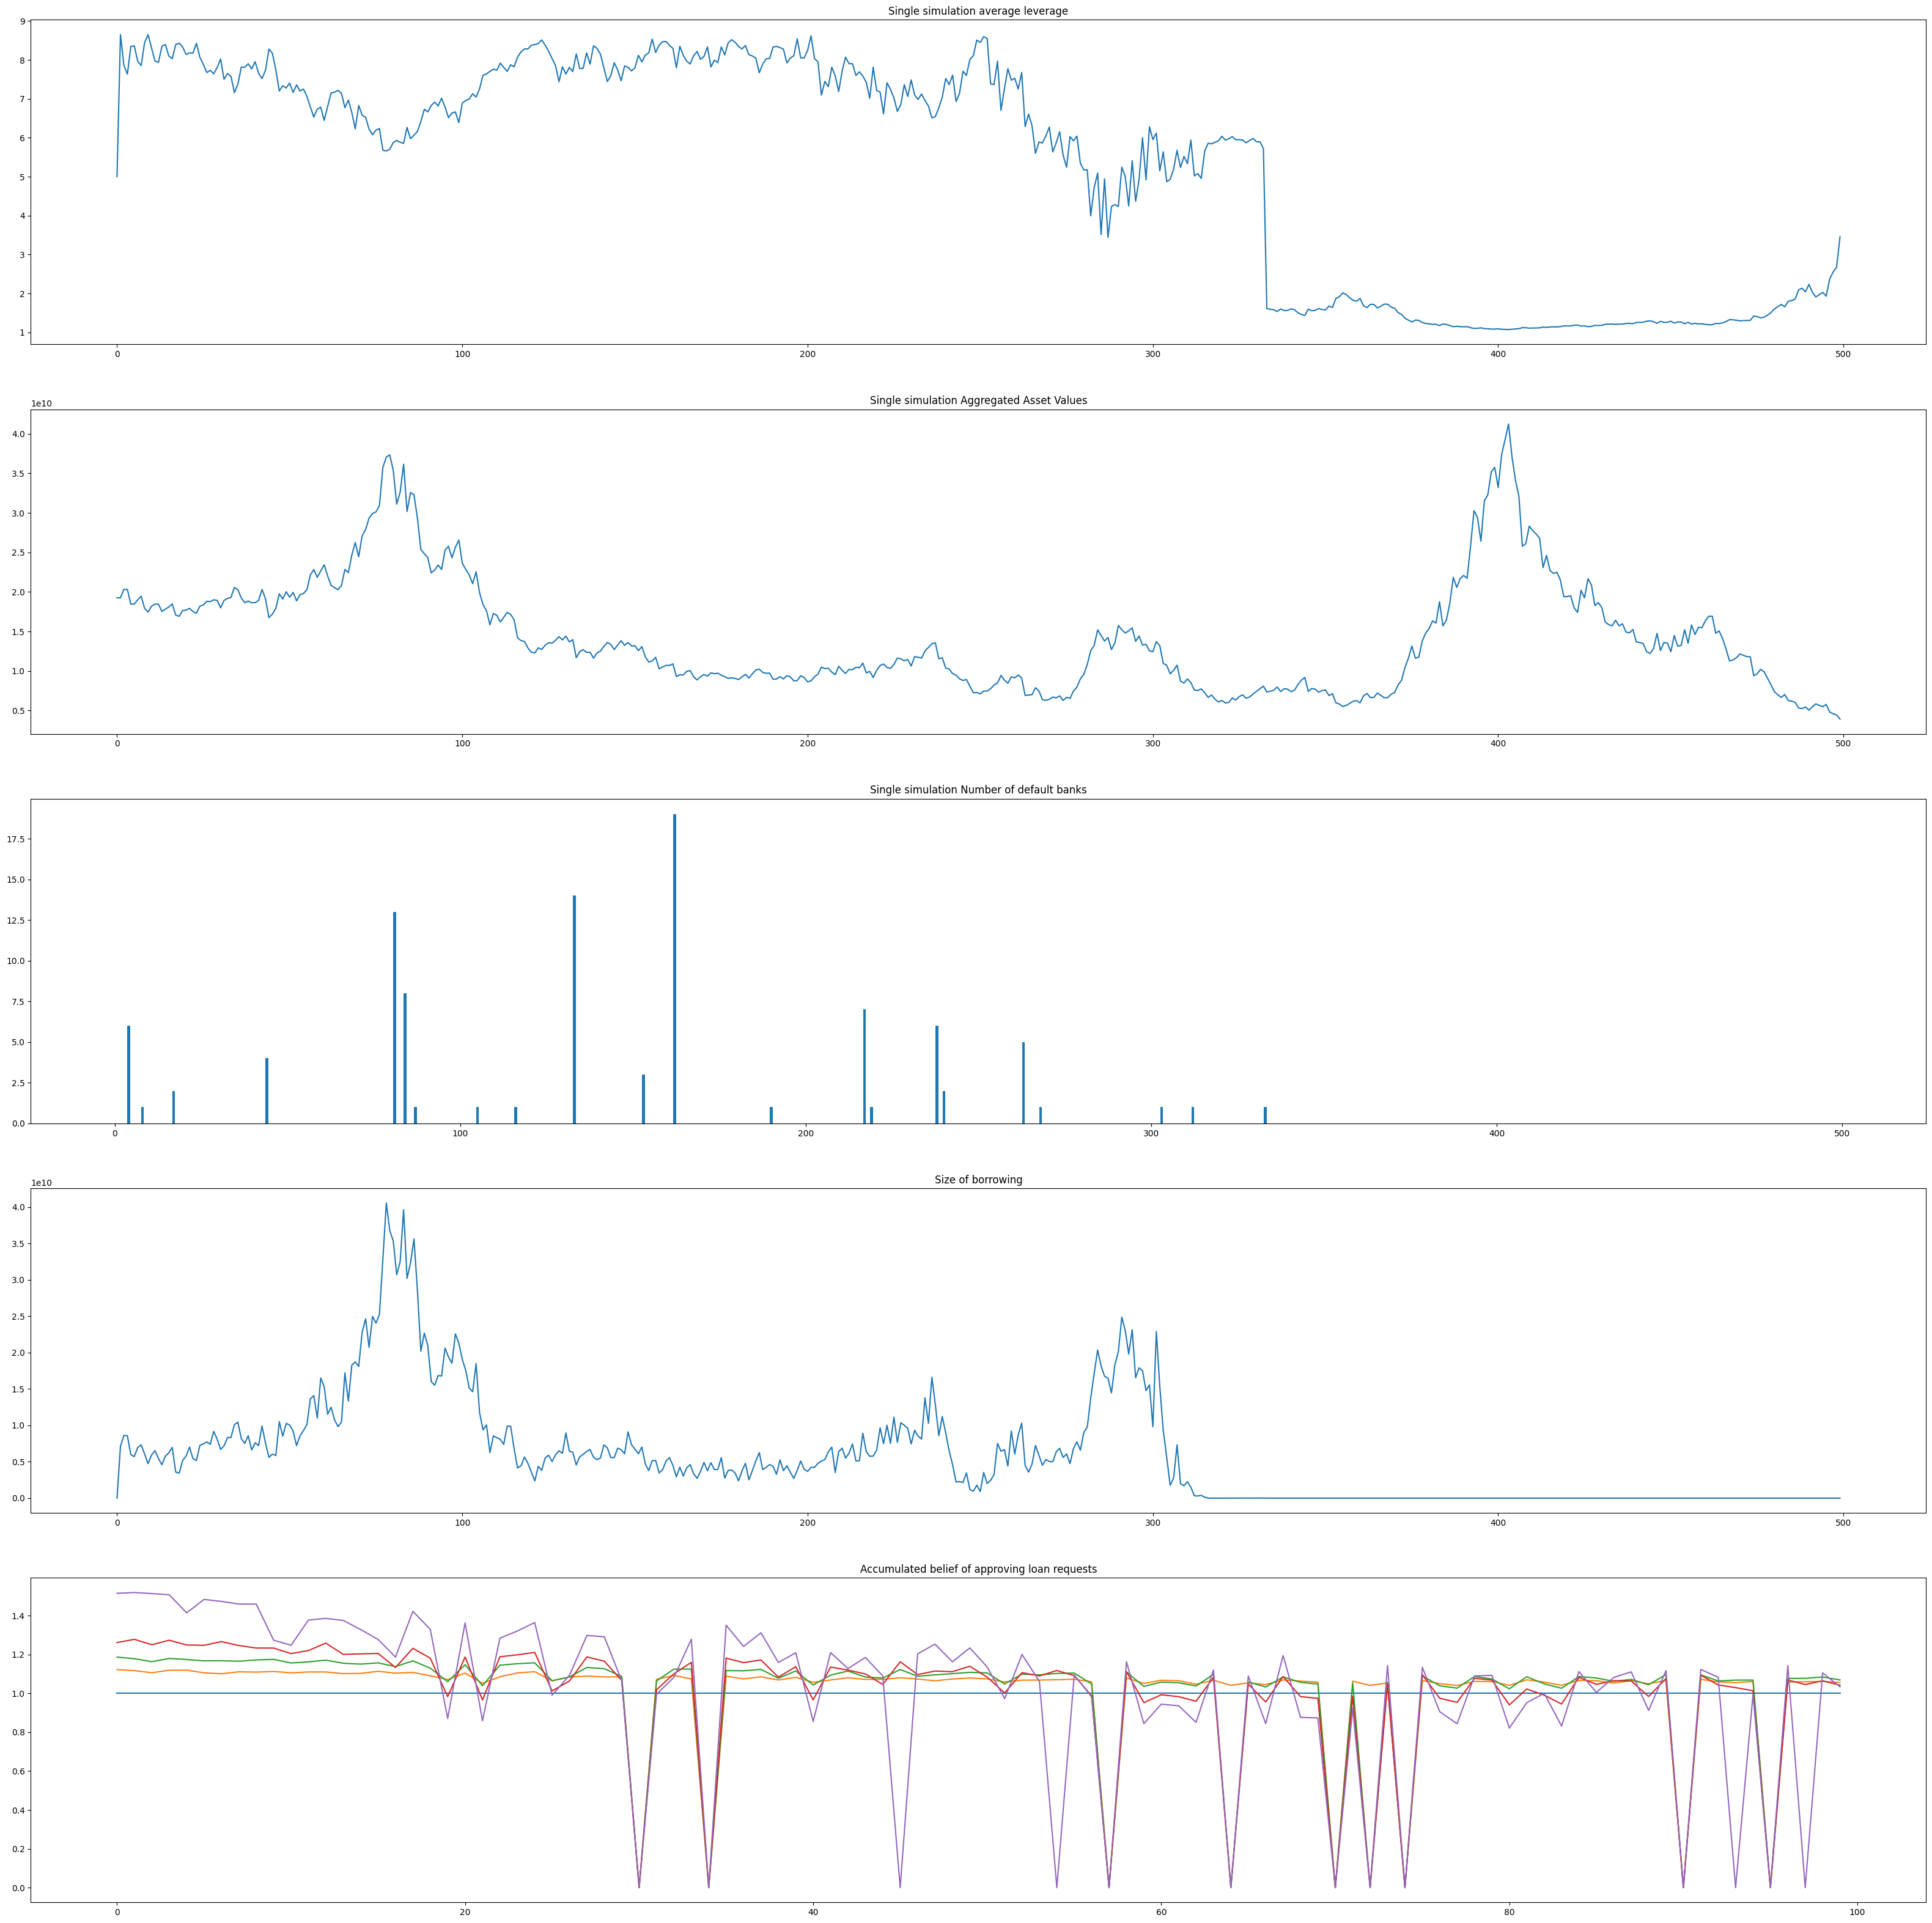

In [87]:
simulationMonitor(agent_data, model_data, simulationSteps)

In [20]:
def run():
    # simulation and data collection
    simulationSteps = 500
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 10.0,                                     # leverage ratio upper bound for all banks
                    capitalReserve = 0.0,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 20,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1.0,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.99,                                              # portfolio recovery rate                           
                    beta = 0.99,                                               # interbank loan recovery rate
                    fedRate = 0.04,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.10,                                # return rate on portfolio
                    returnVolatiliy = 0.18,
                    returnCorrelation = np.diag(np.ones(100)),
                    liquidityShockNum = 2,                                    # number of liquidity shocks per step      
                    shockSize = 0.1,                                          # size of the shock
                    shockDuration =  [simulationSteps // 10 * 6, simulationSteps // 10 * 7]) # duration of the shock
                    
    model.datacollector.collect(model)
    for i in tqdm(range(simulationSteps)):
        model.simulate()

    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data, agent_data, model

model_data_collection = []
agent_data_collection = []
model_collection = []
for _ in range(10):
    m, a, model = run()
    model_data_collection.append(m)
    agent_data_collection.append(a)
    model_collection.append(model)

100%|██████████| 500/500 [00:55<00:00,  9.09it/s]


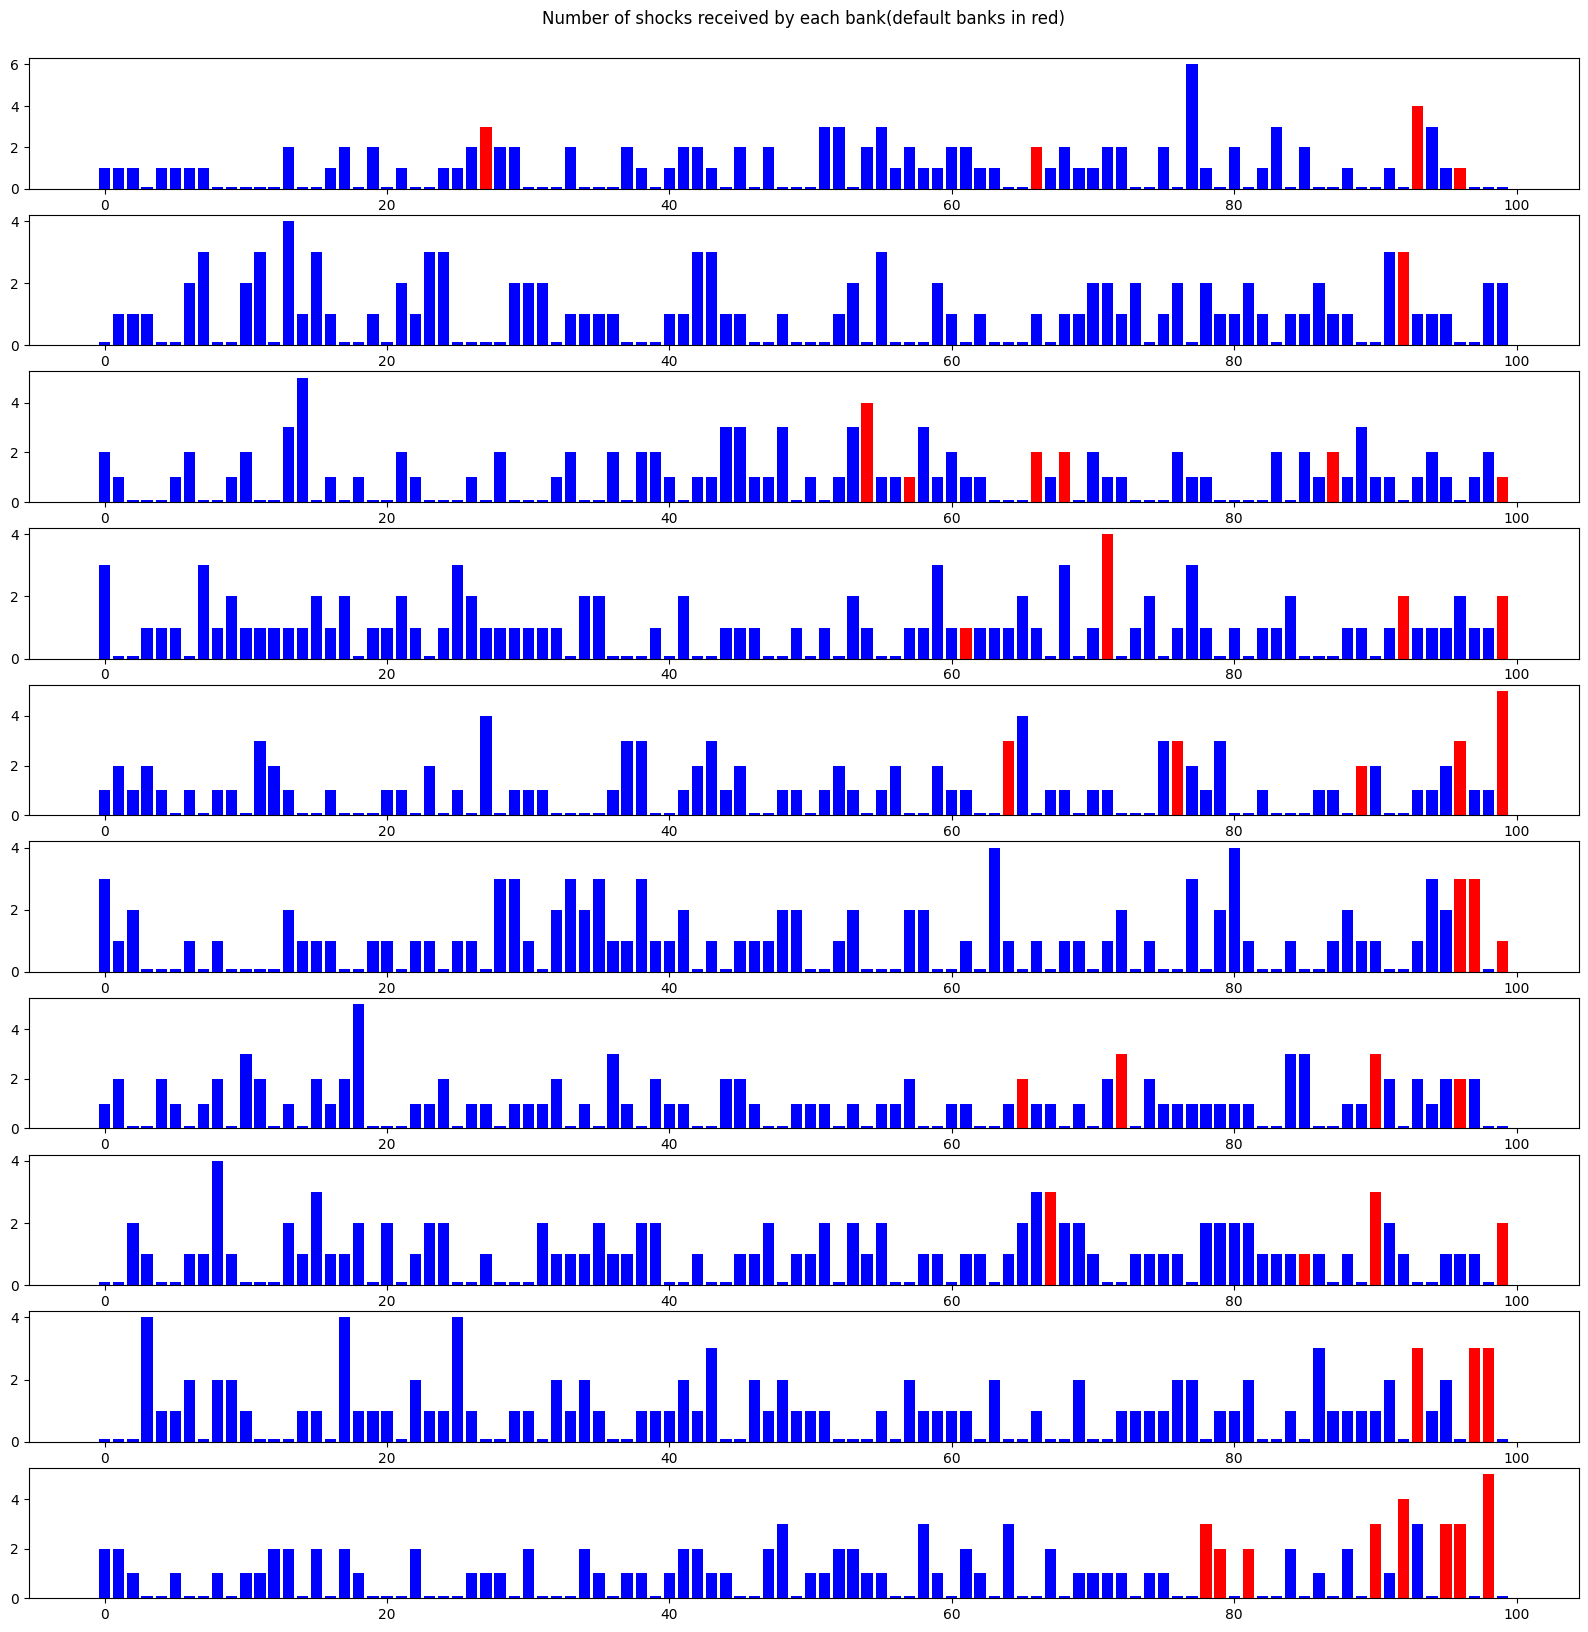

In [21]:
# shock analysis
simulationSteps=500
fig, axes = plt.subplots(nrows=10, ncols=1)
axes = axes.ravel()

plt.title("Number of shocks received by each bank(default banks in red)", y = 12)
for agent_data, model,j in zip(agent_data_collection, model_collection, range(10)):
    agents_df = agent_data.xs(simulationSteps, level="Step")
    defaults = agents_df[agents_df.Default ==True].index
    red_bars = defaults
    keyVals = [] 
    for k, v in model.shockedBanks.items():
        keyVals.append([k,v])
    
    for i in range(100):
        if i not in model.shockedBanks:
            keyVals.append([i,0.1])
    
    keyVals = np.array(keyVals)
    bar_colors = ['red' if i in red_bars else 'blue' for i in keyVals[:,0]]
    axes[j].bar(keyVals[:,0], keyVals[:,1],color=bar_colors)
plt.show()

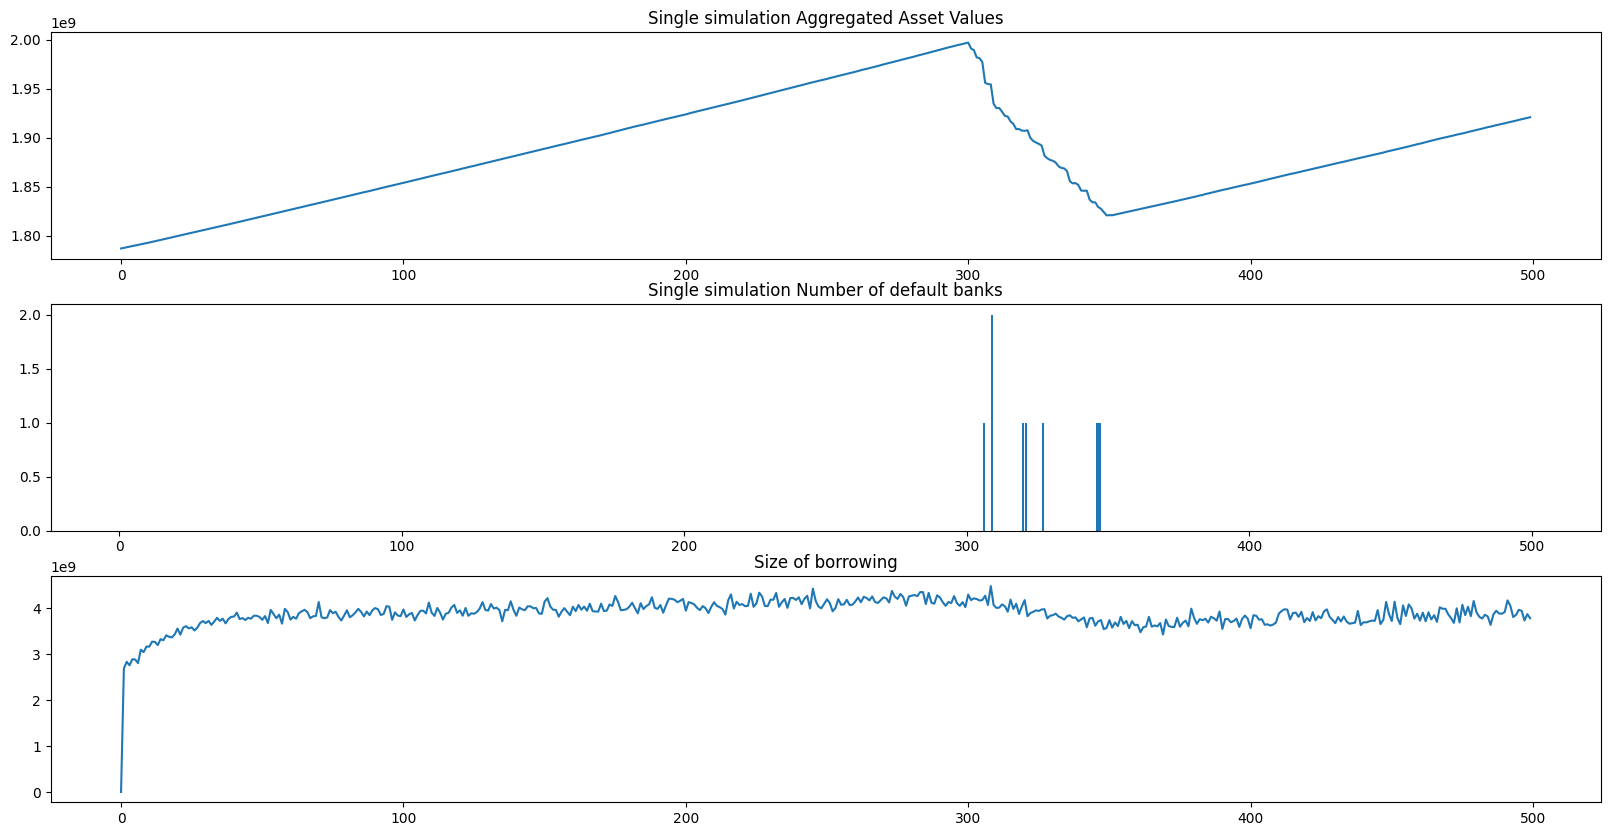

In [22]:
numberOfDefault = [agent_data.xs(i, level="Step")["Default"].sum() for i in range(simulationSteps)]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(20, 10)
ax1.plot(range(simulationSteps), [agent_data.xs(i, level="Step")["PortfolioValue"].sum() for i in range(simulationSteps)])
ax1.set_title("Single simulation Aggregated Asset Values")
ax2.bar(range(1, simulationSteps), np.diff(numberOfDefault))
ax2.set_title("Single simulation Number of default banks")
ax3.plot(np.array([[model_data_collection[j]["Liability Matrix"][i].sum() for i in range(simulationSteps)] for j in range(10)]).mean(axis=0))
ax3.set_title("Size of borrowing")
plt.show()

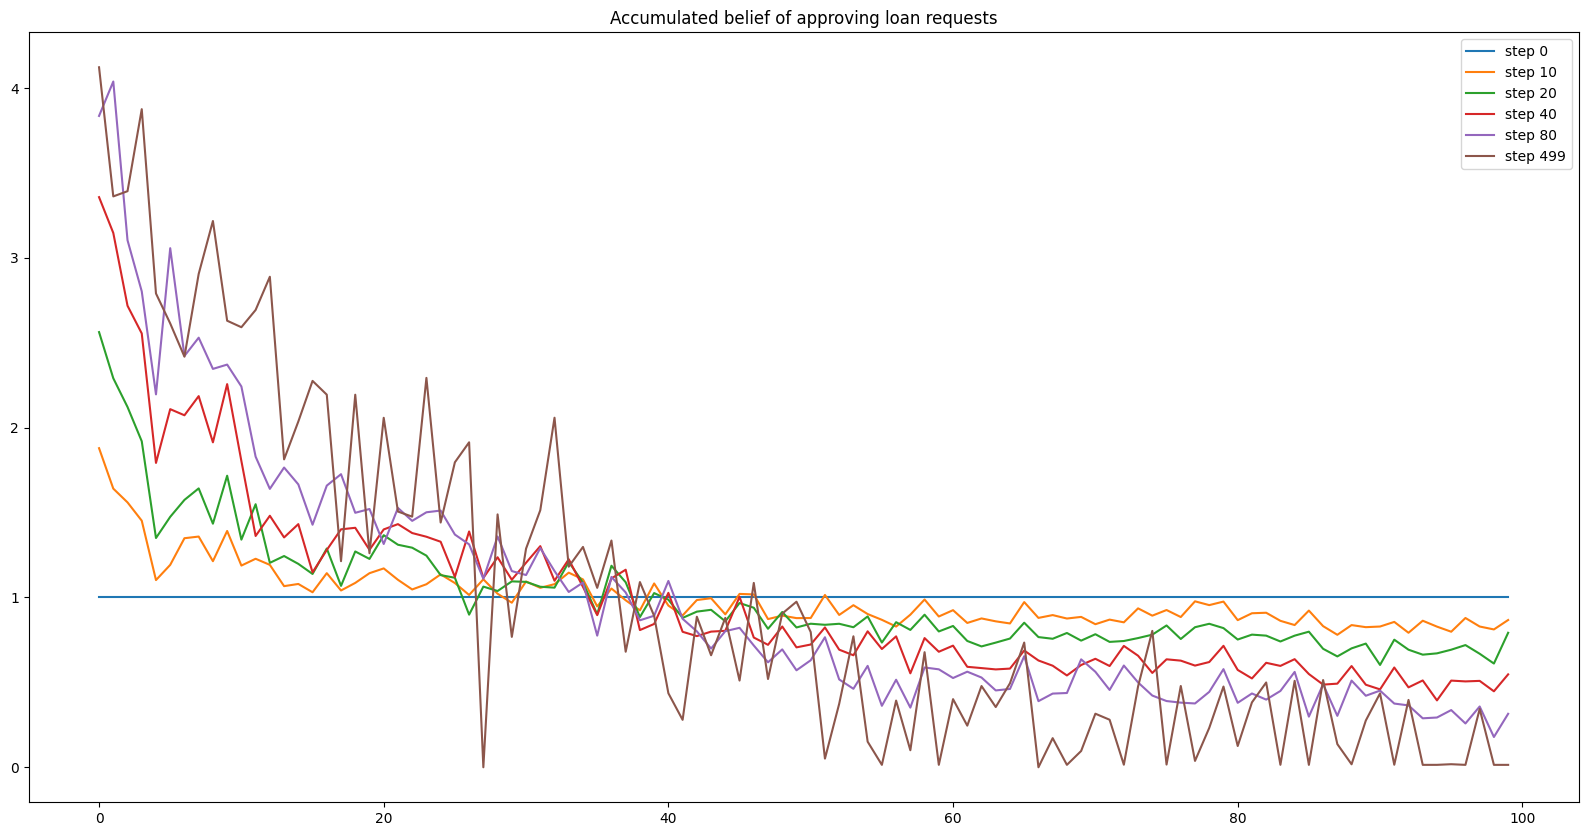

In [23]:
model_data = model_data_collection[0]
plt.figure(figsize=(20,10))
plt.title("Accumulated belief of approving loan requests")
for i in [0,10,20,40,80,499]:
    plt.plot(range(100),model_data["Trust Matrix"][i].sum(axis = 0), label = "step " + str(i))
plt.legend()

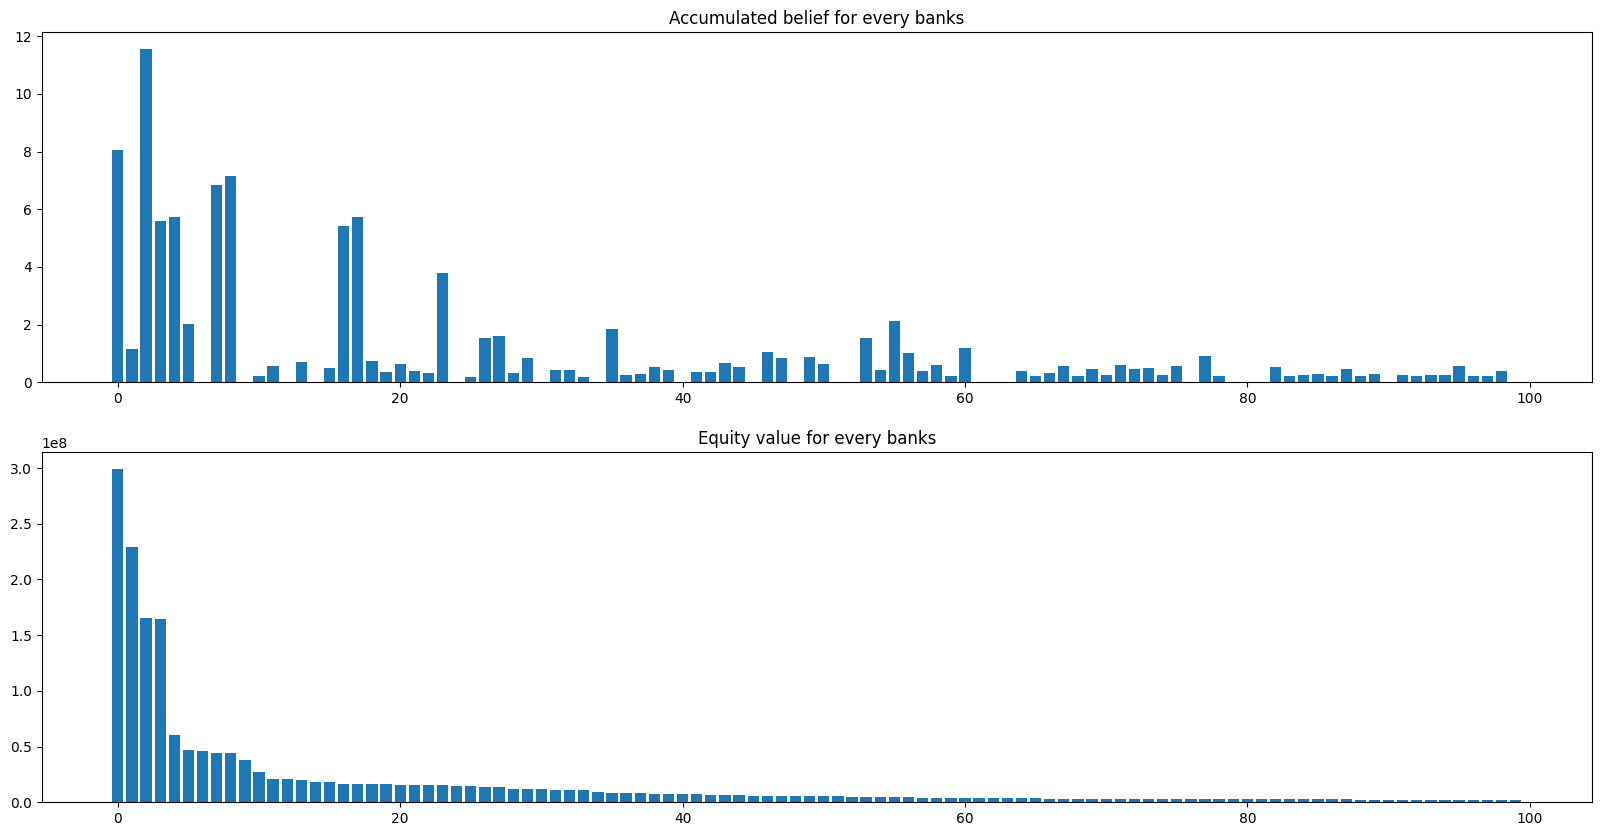

In [99]:
# bar chart of portfolio value
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(20, 10)
ax1.bar(range(model.N), model_data["Trust Matrix"][simulationSteps].sum(axis = 0))
ax1.set_title("Accumulated belief for every banks")
ax2.bar(range(model.N), agent_data.xs(0, level="Step")["Equity"])
ax2.set_title("Equity value for every banks")
plt.show()

In [25]:
model.banks.head(10)

0    JPMORGAN CHASE BANK, NATIONAL ASSOCIATION
1        BANK OF AMERICA, NATIONAL ASSOCIATION
2       WELLS FARGO BANK, NATIONAL ASSOCIATION
3                               CITIBANK, N.A.
4                                  TRUIST BANK
5               PNC BANK, NATIONAL ASSOCIATION
6               U.S. BANK NATIONAL ASSOCIATION
7                                TD BANK, N.A.
8                       GOLDMAN SACHS BANK USA
9            CAPITAL ONE, NATIONAL ASSOCIATION
Name: bank, dtype: object

In [26]:
increaseLeverage = np.array([ 1.19996394,  1.29992862,  1.59976513,  1.59984237,  4.09683278,
        3.89731372,  3.99710619,  3.09865677,  3.69784216,  4.6961778 ,
        4.5971152 ,  5.49541782,  3.89724918,  5.29505129,  5.49587823,
        3.79807092,  4.6970062 ,  6.69220866,  4.89690531,  5.49585307,
        4.99513589,  4.29750458,  3.79708461,  5.99410685,  4.19775631,
        6.39435126,  5.59520562,  6.19425253,  6.89291176,  5.8946971 ,
        6.09492901,  5.19580941,  6.89291436,  5.4952217 ,  5.79427931,
        6.79252838,  7.09172193,  5.29538254,  6.29438721,  6.29172312,
        6.59335353,  6.69332769,  6.29272486,  6.49357311,  5.39585479,
        8.19006168,  6.09425534,  6.99209137,  6.49343307,  7.19265758,
        6.39400867, 10.58311008,  7.09284303,  7.39174492,  8.58917861,
        8.68796199,  7.78975665,  9.38642647,  8.98735847,  6.7934997 ,
        8.689263  ,  8.98838558,  7.69132145,  8.6886021 ,  8.8870582 ,
        6.89137761,  9.08802718,  7.39193573,  8.38898613,  5.89379391,
        8.19008096,  8.18999515,  7.59100582,  8.48907156, 10.18344328,
        9.58496291,  9.88538145,  9.08707639,  9.58666637,  8.08999116,
        6.59394342,  7.39183229,  8.29077146, 10.08434621,  8.68780753,
        7.09286309,  9.68600817, 10.88294344,  9.38676417,  9.88585291,
        9.78577908, 10.78222466,  8.18883144, 10.98169289,  8.58872027,
        9.18784871,  9.38736715,  9.48621965, 10.1839301 , 10.68200396])

diverseLoanLeverage = np.array([1.76647084, 2.13301217, 2.76579031, 2.33282825, 3.13228433,
       2.43285198, 3.69837873, 4.16469683, 4.26407998, 4.69705864,
       6.46108018, 4.19735471, 5.86237234, 4.56423693, 5.26309153,
       4.89705628, 4.83047138, 5.26340149, 4.49745936, 6.29421769,
       4.92990568, 5.99563935, 5.59596605, 4.63018879, 5.72904307,
       5.36270788, 5.79538571, 4.36414654, 5.99507042, 4.99659221,
       5.52966845, 6.02838299, 6.06142473, 5.16310337, 7.42539263,
       5.82843146, 5.82862316, 6.42778743, 6.16116303, 5.36297969,
       6.49412157, 5.66265491, 6.86048187, 8.0913745 , 7.19333111,
       6.56128269, 5.22906351, 6.52716724, 6.95994647, 7.85838915,
       6.52780117, 6.59402876, 6.49372408, 7.52582939, 5.76220094,
       6.99328865, 6.76021846, 6.06182856, 7.82505972, 6.42824264,
       7.59169308, 6.66013857, 6.12800269, 6.49416976, 6.29463786,
       7.49234495, 6.66066229, 6.09494039, 7.02715966, 8.45711027,
       7.39228155, 7.52542544, 7.79148803, 7.52594992, 6.36107241,
       6.82696499, 7.02693993, 6.66090797, 6.12792201, 6.22824504,
       7.02612358, 6.42797501, 6.52741495, 7.192109  , 7.0262109 ,
       6.99275581, 6.56080797, 6.72734835, 8.75624932, 7.59185347,
       6.26118114, 6.76056006, 7.22588921, 5.99499735, 6.32797083,
       8.05744044, 6.12761458, 7.7915964 , 7.49222643, 7.59222921])

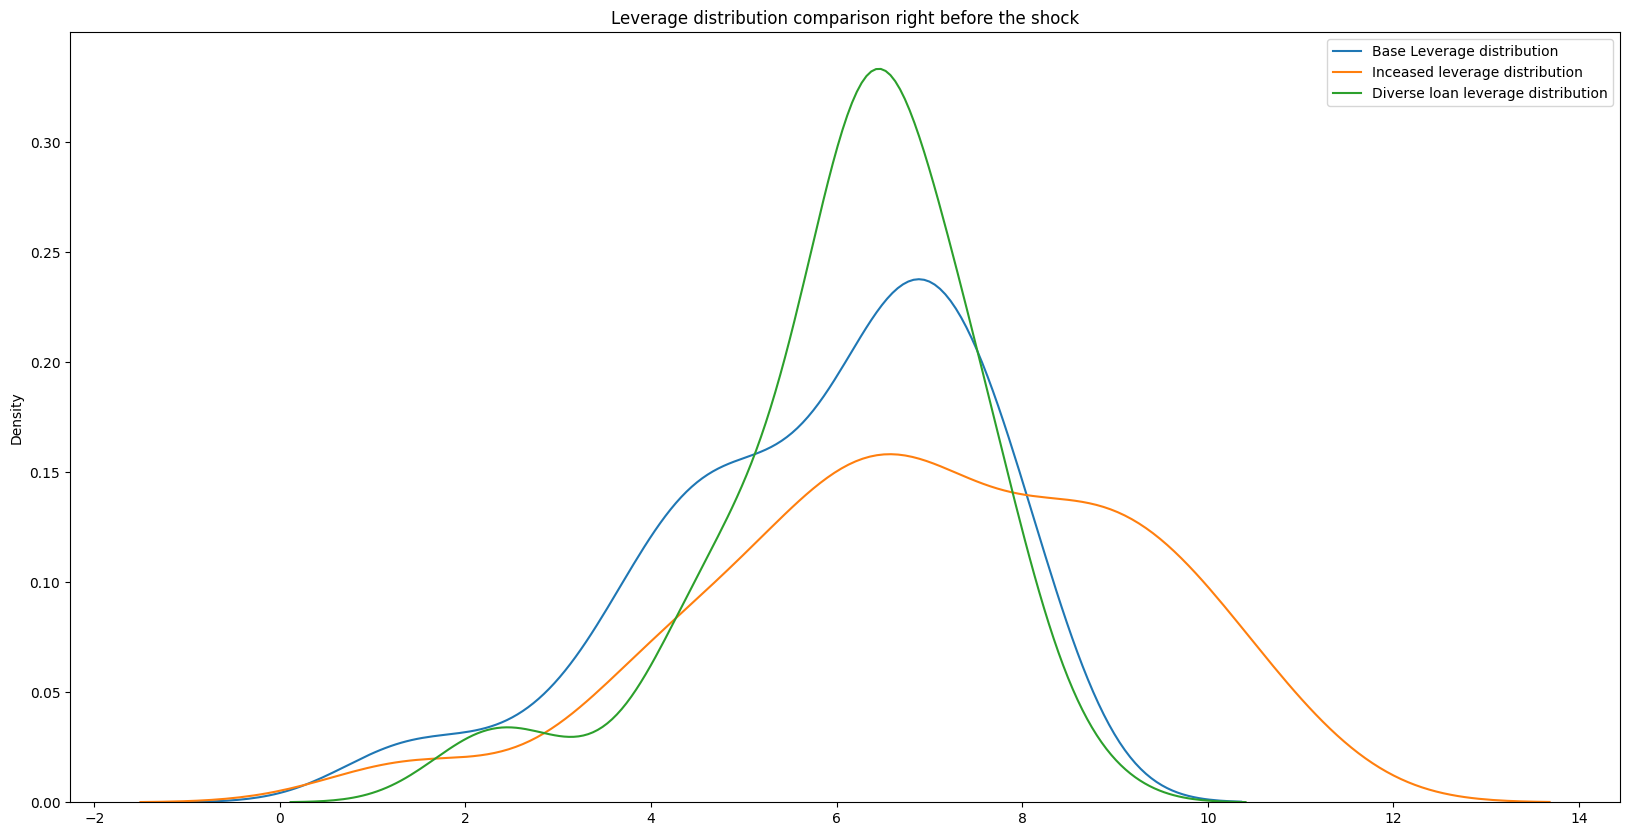

In [27]:
import seaborn as sns
leverages = 0
for agent_data in agent_data_collection:
    leverages += agent_data.xs(300, level="Step")["Leverage"].values
plt.figure(figsize=(20,10))
plt.title("Leverage distribution comparison right before the shock")
sns.kdeplot(leverages/len(agent_data_collection), label = "Base Leverage distribution")
sns.kdeplot(increaseLeverage, label = "Inceased leverage distribution")
sns.kdeplot(diverseLoanLeverage, label = "Diverse loan leverage distribution")
plt.legend()